# Imports

In [1]:
from modules.data import data_loader, data_splitter, data_reader
from modules.models import arima, lag_llama, autoregressor
from modules.evaluation import evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from modules.experiment.experiment import run_experiment
from modules.data.tscv import create_tscv_dataset
from modules.experiment.tscv import get_tscv_results, mean_directional_accuracy, get_summary, extract_metrics
from modules.visualization import graphs


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import islice
from sklearn.model_selection import TimeSeriesSplit
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Parameters

In [2]:
PREDICTION_LENGTH = 5 # currentlz only works for PREDICTION_LENGTH > 1
FREQUENCY = "daily" # currently we only have dailz frequency
TYPE_OF_DATA = "return" # currently we only have stock prices saved
MODELS = ["arima", "llama", "autoregressor"] # currentlz works onlz for these two
FOLDS = 5 # for TSCV
CONTEXT_LENGTH = 64

model_names = ['Arima', 'Lag LLama', 'Autoregressor']

# Extracting summary statistics for each model
metrics = ['r2', 'mse', 'mae', 'rmse', 'mda']

#START_DATE = 
#END_DATE
# want to add
#TRAIN_PERIOD = # context lenghts. Should take a look into this
#TRAIN_SIZE = 




# Notes

 - autoregressor
 - mean directional accuracy
 - ask
 - for each time-series create a whole dataframe for TSCV
  - problem with this is with time horizon that is >1 
  - prediction horizon is only for that value in the future

# TO DO

 - create the TSCV experiment. It needs to create a table. Metrics for each fold
 - lit review
 - content for the presentation by monday!!
 - review data leakage risk
 - writing of the dissertation
 - autoregressor
 - MDA metric
 - frequency

 Writing
 - lit review
 - lit reading

# Loading the data

In [3]:
data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY)
# this is just in case there are more CSVs of the same type and frequency, the data should be the first in the list
#if len(data) > 1:
data = data[0]

simple_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["simple"])
#if len(simple_data) > 1:
simple_data = simple_data[0]

train_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["train"])
train_data = train_data[0]

test_data = data_reader.read_data(type = TYPE_OF_DATA, frequency = FREQUENCY, match = ["test"])
test_data = test_data[0]

# Prepare the data

In [4]:
# pass full data at maximum granularity and produce according to frequency parameter

In [6]:
#tscv_data = create_tscv_dataset(data = simple_data, context_length=CONTEXT_LENGTH, n_folds=FOLDS, prediction_horizon=PREDICTION_LENGTH, max_folds=False)

# Models

In [7]:
# arima


In [8]:
# lag llama

# SKLearn TSCV

In [4]:
r, p, a = get_tscv_results(simple_data, PREDICTION_LENGTH, CONTEXT_LENGTH, FOLDS, frequency=FREQUENCY)

Fold 1/5 finished in: 4.81 seconds
Prediction from   2024-06-03   until   2024-06-07
----------------------
Fold 2/5 finished in: 4.61 seconds
Prediction from   2024-06-10   until   2024-06-14
----------------------
Fold 3/5 finished in: 4.56 seconds
Prediction from   2024-06-17   until   2024-06-24
----------------------
Fold 4/5 finished in: 4.79 seconds
Prediction from   2024-06-25   until   2024-07-01
----------------------
Fold 5/5 finished in: 4.56 seconds
Prediction from   2024-07-02   until   2024-07-09
----------------------


In [5]:
#creating the summary for each model
s = [get_summary(r[i]) for i in range(len(r))]

In [8]:
means_df, medians_df, stds_df = extract_metrics(s, MODELS)

# Visualisation

In [ ]:
graphs.standard_visualisation(model_names, metrics, s)

In [ ]:
graphs.interactive_visualisation(model_names, metrics, s)

In [ ]:
graphs.prediction_visualisation(model_names, p, a)

LABEL the graph
label the axes with timestamps
show the history of the actual
table of comparison, not just graph

# Fine-tuning lag-llama

In [7]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [8]:
ckpt_path = "modules/models/llama/ft-lag-llama.ckpt"

import torch

from lag_llama.gluon.estimator import LagLlamaEstimator

ckpt = torch.load(ckpt_path, map_location=torch.device("cpu"))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path=ckpt_path,
        prediction_length=PREDICTION_LENGTH,
        context_length=CONTEXT_LENGTH,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=10,
        num_parallel_samples=100,
        trainer_kwargs = {"max_epochs": 30,}, # <- lightning trainer arguments
    )

In [9]:
ft_train_data = lag_llama.prepare_data(train_data, 0, FREQUENCY)

In [11]:
predictor = estimator.train(ft_train_data, cache_data = True, shuffle_buffer_length = 1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\topco\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached -2.76939 (best -2.76939), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_2\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -3.29597 (best -3.29597), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_2\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached -4.20981 (best -4.20981), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation\\lightning_logs\\version_2\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached -4.65978 (best -4.65978), saving model to 'c:\\Users\\topco\\Dokumenti\\MSc Banking and Digital Finance UCL\\Modules\\Dissertation\\MSc_dissertation

In [34]:
ft_test_data = lag_llama.prepare_data(test_data, 0, FREQUENCY)

In [35]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=ft_test_data,
        predictor=predictor,
        num_samples=100
    )

In [36]:
forecasts = list(tqdm(forecast_it, total=len(ft_test_data), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
ft_lag_llama_forecast = forecasts[0].samples.mean(axis = 0)

In [38]:
ft_lag_llama_forecast

array([0.0036107 , 0.        , 0.01122168, 0.        , 0.        ])

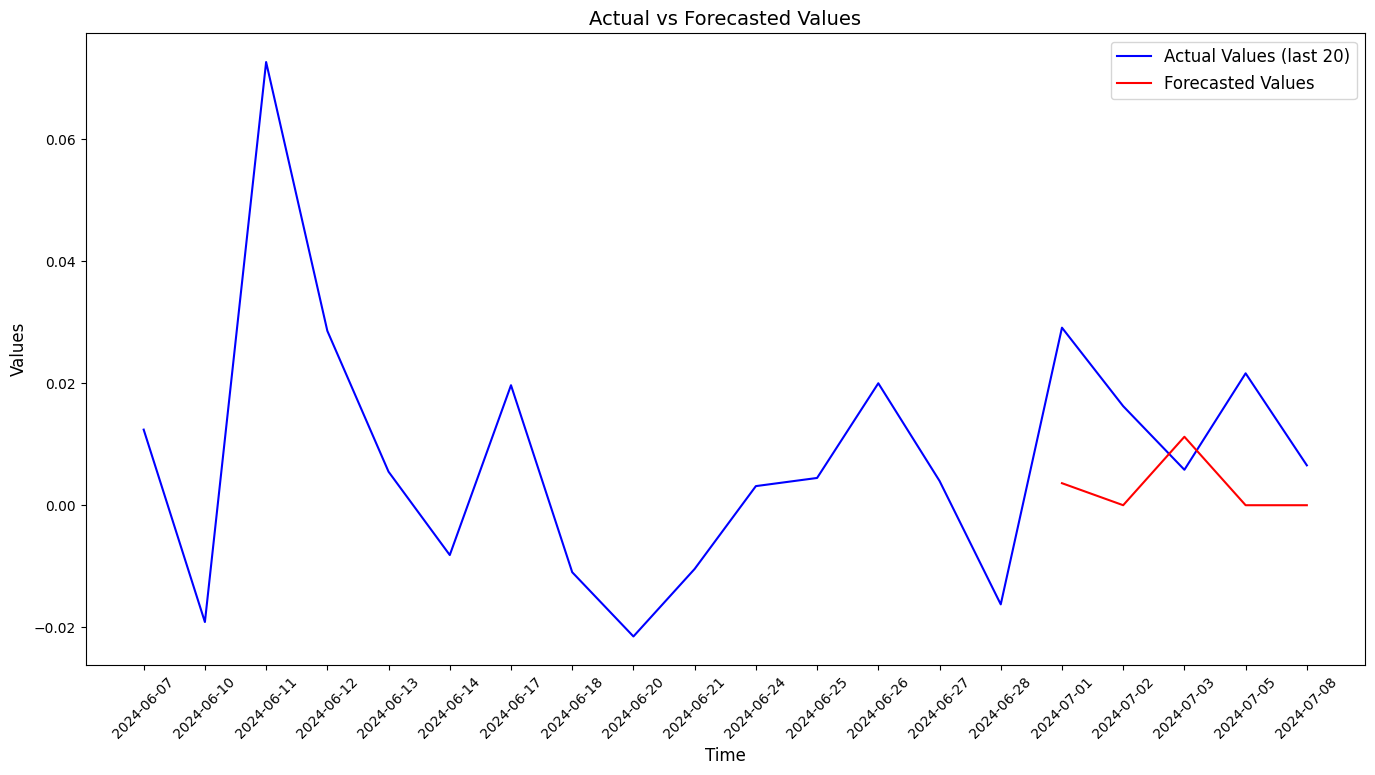

In [40]:
import matplotlib.pyplot as plt

# Assuming you have the following variables
# ft_lag_llama_forecast: a numpy array or list of forecasted values
# PREDICTION_LENGTH: an integer denoting the length of ft_lag_llama_forecast
# test_data: a pandas DataFrame with columns 'ds' and 'y'

# Getting the last 20 values of 'y' from test_data
last_20_y = test_data['y'].tail(20)

# Getting the last PREDICTION_LENGTH timestamps from test_data
last_prediction_timestamps = test_data['ds'].tail(PREDICTION_LENGTH)

# Create a larger figure
plt.figure(figsize=(14, 8))

# Plotting the last 20 values of 'y' in blue
plt.plot(test_data['ds'].tail(20), last_20_y, label='Actual Values (last 20)', color='blue')

# Plotting the ft_lag_llama_forecast values in red
plt.plot(last_prediction_timestamps, ft_lag_llama_forecast, label='Forecasted Values', color='red')

# Adding labels and title with smaller fonts
plt.xlabel('Time', fontsize=12)
plt.ylabel(TYPE_OF_DATA, fontsize=12)
plt.title('Actual vs Forecasted Values', fontsize=14)
plt.legend(fontsize=12)

# Adjusting x-axis labels to be smaller
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Adjusting layout to fit everything
plt.tight_layout()

# Displaying the plot
plt.show()



# Previous experiment with fine-tuning

In [51]:
import yfinance as yf
import pandas as pd

ticker_symbol = 'AAPL'

# Define the date range
start_date = '2024-07-10'
end_date = '2024-07-17'

# Download the data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Extract and display the Close prices
close_prices = data['Close']
print(close_prices)

[*********************100%%**********************]  1 of 1 completed
Date
2024-07-10    232.979996
2024-07-11    227.570007
2024-07-12    230.539993
2024-07-15    234.399994
2024-07-16    234.820007
Name: Close, dtype: float64


In [54]:
ticker_symbol = 'AAPL'

# Define the date range
start_date = '2024-07-09'
end_date = '2024-07-17'  # Slightly beyond the 14th to ensure we get 5 returns

# Download the data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Calculate daily returns
data['Daily Return'] = data['Close'].pct_change()

# Extract the relevant daily returns
daily_returns = data['Daily Return'].dropna().iloc[:5]

# Display the daily returns
print(daily_returns)

[*********************100%%**********************]  1 of 1 completed
Date
2024-07-10    0.018804
2024-07-11   -0.023221
2024-07-12    0.013051
2024-07-15    0.016743
2024-07-16    0.001792
Name: Daily Return, dtype: float64


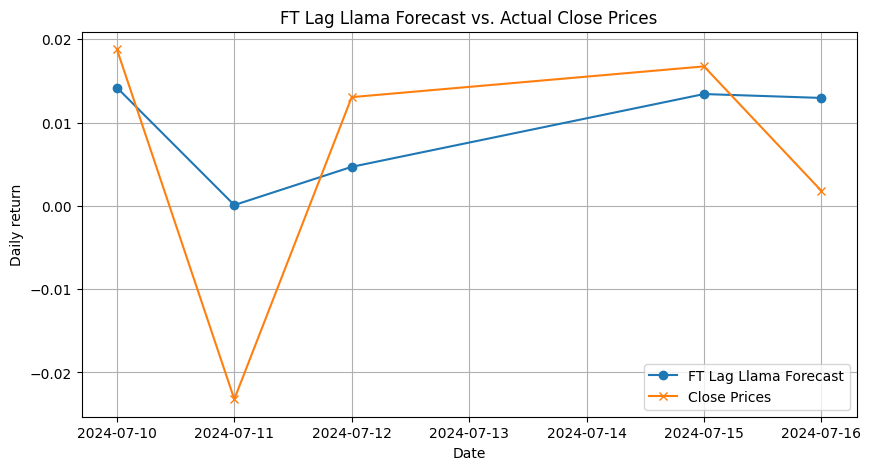

In [56]:
dates = pd.date_range(start='2024-07-10', end='2024-07-16', freq='B')

ft_lag_llama_forecast_series = pd.Series(ft_lag_llama_forecast, index=dates)
close_prices_series = pd.Series(daily_returns, index=dates)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(ft_lag_llama_forecast_series, label='FT Lag Llama Forecast', marker='o')
plt.plot(close_prices_series, label='Close Prices', marker='x')

# Adding title and labels
plt.title('FT Lag Llama Forecast vs. Actual Close Prices')
plt.xlabel('Date')
plt.ylabel('Daily return')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()